# Data analysis

The aim of this notebook is to predict the in hospital death in ICU visit based on the first 24 hours of ICU stay data.

In [15]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import seaborn as sns
import urllib.request
import zipfile
import os
from time import time

# custom py files
import dtw
import KNN
import visuals as vs

# for pretty printing pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('seaborn-notebook')

## Download the data

In [2]:
# generate a data folder, we store all data in this folder
if not os.path.exists('data'):
    os.makedirs('data')
    
# download and unzip the rawdata
url = 'https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdk96S3k0djAydHpndFU0OGphUW9DMU5QR1VOTGc/root/content'
urllib.request.urlretrieve(url, "download.zip")

with zipfile.ZipFile("download.zip","r") as zip_ref:
    zip_ref.extractall("data")  

## Functions 

In [3]:
def get_path(filename, suffix):
    """
    Return the path of the file.
    
    iuputs:
      - filename: string that points the file
      - suffic: string that indicates the file format
    """
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data')
    return os.path.join(dir_name, filename + "." + suffix)   

## Load the data
These are train, valid, and test data, and all of them are loaded into a dictionary named 'data'. 
The multi-index represents two dimensions, patient id and time.

In [4]:
names = ['X_train', 'X_test', 'y_train', 'y_test']

data = {(name):(pd.read_csv(get_path(name, 'csv'), index_col = [0,1]) if name.split('_')[0] == 'X' 
                else pd.read_csv(get_path(name, 'csv'), index_col = 0)) for name in names }

## DTW data
Then, we generate the data for the dynamic time wrapping (DTW) kNN classifier.


In [5]:
# data for DTW kNN classifier
data_dtw = {}

for X in ['X_test', 'X_train']:
    df = data[X]
    data_dtw[X] = []
    for key, value in df.groupby(level=0):
        data_dtw[X].append(value.values)
    data_dtw[X] = np.array(data_dtw[X])

## Data for conventional classifiers

Besides using the DTW kNN, we also use conventional classifiers to predict the in hospital death. But, first we need to extract new features from the multivariate time series and to reduce the dimensions of the data from 3D to 2D.

In [6]:
# data for conventional classifiers
data_agg = {}

# extract the statistical properties such as mean, median, max, min, std for each patient using groupby in Pandas
for name, df in data.items():
    data_agg[name] = df.groupby('id').agg([np.median, max, min, np.mean, np.std])
    data_agg[name].columns = ['_'.join( ( col[0], col[1])) for col in data_agg[name].columns]

Also, we also interest on the number of data points below or above the global Q1 and Q3 for each patient. 

In [7]:
# Function to count the data points belowe/above the threshold
def count_below_threshold(array, threshold):
    '''Count the data points that below the threshold in the time series'''
    return np.sum(array < threshold.reshape(1,array.shape[1]), axis=0)/array.shape[0]

def count_above_threshold(array, threshold):
    '''Count the data points that above the threshold in the time series'''
    return np.sum(array > threshold.reshape(1,array.shape[1]), axis=0)/array.shape[0]

data_quartiles = {}

# constants
count_funcs = [count_below_threshold, count_above_threshold]
column_names = ['below_Q1', 'above_Q3']
quartiles = {key: data["X_train"].quantile(value) \
             for (key,value) in zip(['Q1', 'Q3'], [0.25, 0.75])} # global quantiles of trainig data

# Loop to greate new features and store them in data_quartiles
for name, df in data.items():
    if name.split('_')[0] == 'X': # Only consider the training data
        data_quartiles[name] = {}
        for Q, func, column in zip(['Q1', 'Q3'], count_funcs, column_names):
            data_quartiles[name][Q] = df.groupby('id').apply(lambda x: func(x, quartiles[Q].values))
            data_quartiles[name][Q].columns = ['_'.join( ( col, column)) for col in data_quartiles[name][Q].columns]
            
# Concat data_quantile into data_agg
for name in ['X_train', 'X_test']:
    combined_df = pd.concat( [data_quartiles[name]['Q1'], data_quartiles[name]['Q3'], data_agg[name]], axis =1)
    data_agg[name] = combined_df

## Calculation the benchmark scores

In [8]:
from sklearn.metrics import f1_score, matthews_corrcoef

# store the scores into a dictionary
score_metrics = {'f1': f1_score, 'mcc': matthews_corrcoef}

# create the score for benchmark
score_benchmark = {}

# performance of benchmark
for name, func in score_metrics.items():
    score_benchmark[name+'_test'] = func(data['y_test']['in_hospital_death'], data['y_test']['sapsii_prediction'])
    score_benchmark[name+'_train'] = func(data['y_train']['in_hospital_death'], data['y_train']['sapsii_prediction'])

print("The F1 score and MCC of the benchmark of testing data are: {}, {}".format(score_benchmark['f1_test'], 
                                                                                 score_benchmark['mcc_test']))

# performance of naive learner
score_naive = {}
# on the subset of testing samples
score_naive['f1_test'] = f1_score(data['y_test']['in_hospital_death'][:480], np.ones( (480,) ))
score_naive['mcc_test'] = matthews_corrcoef(data['y_test']['in_hospital_death'][:480], np.ones( (480,) ))

print("The F1 score and MCC of the naive perdictor are: {}, {}".format(score_naive['f1_test'], score_naive['mcc_test']))

The F1 score and MCC of the benchmark of testing data are: 0.3713768115942029, 0.28981016250795055
The F1 score and MCC of the naive perdictor are: 0.2189239332096475, 0.0


C:\Users\richa\Anaconda3\envs\mlnd_cp\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## Prediction with DTW kNN classifier

Here, this is the first attempt to train the learner as a DTW with KNN classifier.

In [52]:
results = {}

# Custom metric
def dtw_metric(a,b):
    similarity, _ = dtw.dynamic_time_wraping(a,b, distance.euclidean)
    return similarity

# initize the classifier
dtw_kNN_clf = KNN.KNNClassifier(metric=dtw_metric)

# First, we start with 1922 training samples since kNN is a slow classifier
start = time() # Get start time
dtw_kNN_clf.fit(data_dtw['X_train'][:1922], data['y_train']['in_hospital_death'][:1922])
end = time() # Get end time
    
# Record the training time
results['train_time'] = end - start
    
# Make predictions on train subset (with the size of test set) and test set
start = time() # Get start time
predictions_test = dtw_kNN_clf.predict(data_dtw['X_test'][:480])
end = time() # Get end time
results['pred_time'] = end - start
            
# Compute F-score on the train subset and test set
for name, func in score_metrics.items():
    results[name+'_test'] = func(data['y_test']['in_hospital_death'][:480], predictions_test)
        
# Return the results
results

{'f1_test': 0.27499999999999997,
 'mcc_test': 0.26115948683576662,
 'pred_time': 2243.833170413971,
 'train_time': 0.0030078887939453125}

The results suggest the DTW kNN classifier is computational expensive. Its performance is also not very promising.

## Prediction with conventional classifiers

The second attempt in this project is to use usual classification methods such as logistic regression. In this project, logistic regression, decision tree, gradient boost, and multilayer perceptron classifiers are used. 

In [13]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, metrics): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
       - metrics: dictionary to store the metrics 
    '''
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Record the training time
    results['train_time'] = end - start
    
    # Make predictions on train data
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end - start
    
    for score, func in metrics.items():
    # Compute score on the train subset and test set
        results[score+"_train"] = func(y_train, predictions_train)
        results[score+"_test"] = func(y_test, predictions_test)
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial training

LogisticRegression trained on 192 samples.
LogisticRegression trained on 1922 samples.
LogisticRegression trained on 19220 samples.
DecisionTreeClassifier trained on 192 samples.
DecisionTreeClassifier trained on 1922 samples.
DecisionTreeClassifier trained on 19220 samples.
GradientBoostingClassifier trained on 192 samples.
GradientBoostingClassifier trained on 1922 samples.
GradientBoostingClassifier trained on 19220 samples.


C:\Users\richa\Anaconda3\envs\mlnd_cp\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\richa\Anaconda3\envs\mlnd_cp\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


KerasClassifier trained on 192 samples.
KerasClassifier trained on 1922 samples.
KerasClassifier trained on 19220 samples.


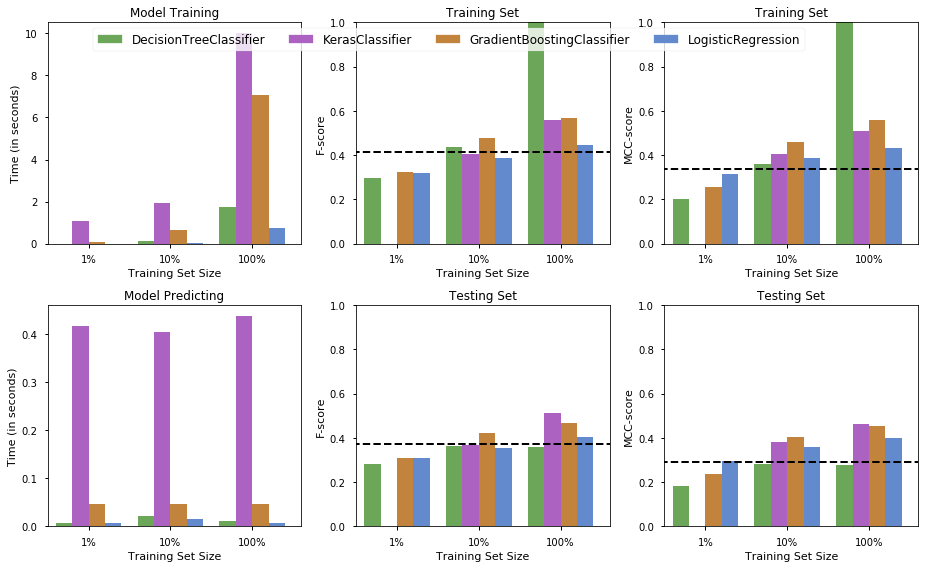

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create keras wrapper
def keras_model():
    # create model
    clf_MLP = Sequential()
    clf_MLP.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(32, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(8, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(1, activation='sigmoid'))
    #clf_MLP.summary()
    clf_MLP.compile(optimizer= 'adam', loss='binary_crossentropy')
    return clf_MLP

# Initialize the three models with default parameters
clf_A = LogisticRegression(random_state = 0) 
clf_B = DecisionTreeClassifier(random_state = 0)
clf_C = GradientBoostingClassifier(random_state=0)
clf_MLP = KerasClassifier(build_fn=keras_model, verbose=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(data['y_train'])
samples_10 = int(round(0.1*samples_100))
samples_1 = int(round(0.1*samples_10))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_MLP]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, 
                      data_agg['X_train'].values, data['y_train']['in_hospital_death'], 
                      data_agg['X_test'].values, data['y_test']['in_hospital_death'], score_metrics)
        
# visualize the results
vs.evaluate(results, score_benchmark)

### Tuning the hyperparameters

We set up a function for using sklearn GridSearch to tune the hyperparameters.

In [21]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def gridsearch(clf, scorer, X_train, y_train, X_test, y_test, parameters):
    """ apply grid search on clf """
    # Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(estimator=clf, scoring=scorer, param_grid=parameters, cv=5)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the best estimator, parameters, and cv_results
    best_clf = grid_fit.best_estimator_
    best_score = grid_fit.best_score_
    best_params = grid_fit.best_params_
    
    cv_results = grid_fit.cv_results_
    means = cv_results['mean_test_score']
    stds = cv_results['std_test_score']
    params = cv_results['params']
    
    print("Best parameters: {}".format(best_params))
    print("Best score: {}".format(best_score))
    for mean, stdev, param in zip(means, stds, params):
        print("mean: {:3f}, std: {:3f} for {}".format(mean, stdev, param))
    
    return best_score, best_params, cv_results

#### Tuning on gradient boost classifier.

In [27]:
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state = 0)

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# we first tune the learning rate of the classifier
learning_rate = np.arange(0.1, 0.31, 0.1)
n_estimators = np.arange(60,101,20)
parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                                    data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                                    data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                                    parameters)

Best parameters: {'n_estimators': 100, 'learning_rate': 0.20000000000000001}
Best score: 0.4918477666968708
mean: 0.461261, std: 0.007083 for {'n_estimators': 60, 'learning_rate': 0.10000000000000001}
mean: 0.474820, std: 0.007641 for {'n_estimators': 80, 'learning_rate': 0.10000000000000001}
mean: 0.480903, std: 0.008068 for {'n_estimators': 100, 'learning_rate': 0.10000000000000001}
mean: 0.482351, std: 0.018550 for {'n_estimators': 60, 'learning_rate': 0.20000000000000001}
mean: 0.489760, std: 0.016931 for {'n_estimators': 80, 'learning_rate': 0.20000000000000001}
mean: 0.491848, std: 0.016384 for {'n_estimators': 100, 'learning_rate': 0.20000000000000001}
mean: 0.484245, std: 0.018319 for {'n_estimators': 60, 'learning_rate': 0.30000000000000004}
mean: 0.487017, std: 0.013921 for {'n_estimators': 80, 'learning_rate': 0.30000000000000004}
mean: 0.488540, std: 0.012584 for {'n_estimators': 100, 'learning_rate': 0.30000000000000004}


In [30]:
# learning rate = 0.2 in this case
clf = GradientBoostingClassifier(random_state = 0)

learning_rate = [0.2]
n_estimators = [100]
max_depth = np.arange(3, 12, 2)
min_samples_split = np.arange(100, 1001, 200)

parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, 
                  max_depth=max_depth, min_samples_split=min_samples_split)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                        parameters)

Best parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 100}
Best score: 0.506621848726305
mean: 0.483613, std: 0.015917 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 100}
mean: 0.490540, std: 0.012502 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 300}
mean: 0.495922, std: 0.015646 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 500}
mean: 0.493662, std: 0.013974 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 700}
mean: 0.490763, std: 0.013912 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 900}
mean: 0.506622, std: 0.010116 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 100}
mean: 0.492320, std: 0.012635 for {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 300}
mean: 0.494381, std: 0.0149

In [33]:
# learning rate = 0.25 in this case
clf = GradientBoostingClassifier(random_state = 0)

learning_rate = [0.2]
n_estimators = [100]
max_depth = [5]
min_samples_split = [100]
min_samples_leaf = np.arange(1, 81, 20)

parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, 
                  max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                        parameters)

Best parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'min_samples_leaf': 1, 'max_depth': 5, 'min_samples_split': 100}
Best score: 0.506621848726305
mean: 0.506622, std: 0.010116 for {'n_estimators': 100, 'learning_rate': 0.2, 'min_samples_leaf': 1, 'max_depth': 5, 'min_samples_split': 100}
mean: 0.501289, std: 0.021659 for {'n_estimators': 100, 'learning_rate': 0.2, 'min_samples_leaf': 21, 'max_depth': 5, 'min_samples_split': 100}
mean: 0.493081, std: 0.010773 for {'n_estimators': 100, 'learning_rate': 0.2, 'min_samples_leaf': 41, 'max_depth': 5, 'min_samples_split': 100}
mean: 0.493425, std: 0.021709 for {'n_estimators': 100, 'learning_rate': 0.2, 'min_samples_leaf': 61, 'max_depth': 5, 'min_samples_split': 100}


Using the tuned parameters to predict the in hospital death.

In [40]:
tuned_GB_clf = GradientBoostingClassifier(random_state = 0, learning_rate=0.2, n_estimators=100, 
                                          max_depth=5, min_samples_split=100, min_samples_leaf=1)

tuned_GB_clf.fit(data_agg['X_train'].values, data['y_train']['in_hospital_death'])

predictions_test = tuned_GB_clf.predict(data_agg['X_test'].values)
    
tuned_GB_clf_results = {}
for score, func in score_metrics.items():
# Compute score on the train subset and test set
    tuned_GB_clf_results[score+"_test"] = func(data['y_test']['in_hospital_death'], predictions_test)
    
print('tuned gradient boost:', tuned_GB_clf_results)

tuned gradient boost: {'f1_test': 0.48437500000000006, 'mcc_test': 0.44859942638115508}


#### Tuning for the Keras MLP classifier

In [22]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create keras wrapper
def keras_model():
    clf_MLP = Sequential()
    clf_MLP.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(32, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(8, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(1, activation='sigmoid'))
    clf_MLP.compile(optimizer= 'adam', loss='binary_crossentropy')
    return clf_MLP

clf = KerasClassifier(build_fn=keras_model, verbose=0)

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# define the grid search parameters
batch_size = [32, 256, 512]
epochs = [10, 50, 100]
parameters = dict(batch_size=batch_size, epochs=epochs)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'].values, data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'].values, data['y_test']['in_hospital_death'], 
                                        parameters)

Best parameters: {'epochs': 50, 'batch_size': 512}
Best score: 0.4950926384628995
mean: 0.480570, std: 0.038959 for {'epochs': 10, 'batch_size': 32}
mean: 0.454648, std: 0.018061 for {'epochs': 50, 'batch_size': 32}
mean: 0.474287, std: 0.021513 for {'epochs': 100, 'batch_size': 32}
mean: 0.436764, std: 0.073502 for {'epochs': 10, 'batch_size': 256}
mean: 0.491214, std: 0.024468 for {'epochs': 50, 'batch_size': 256}
mean: 0.468831, std: 0.025673 for {'epochs': 100, 'batch_size': 256}
mean: 0.445976, std: 0.016769 for {'epochs': 10, 'batch_size': 512}
mean: 0.495093, std: 0.024031 for {'epochs': 50, 'batch_size': 512}
mean: 0.481827, std: 0.018898 for {'epochs': 100, 'batch_size': 512}


In [24]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create model
def keras_model(init_mode='zero'):
    clf_MLP = Sequential()
    clf_MLP.add(Dense(128, kernel_initializer=init_mode, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(8, kernel_initializer=init_mode, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    clf_MLP.compile(optimizer='adam', loss='binary_crossentropy')
    return clf_MLP

clf = KerasClassifier(build_fn=keras_model, verbose=0, epochs=50, batch_size=512)

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
parameters = dict(init_mode=init_mode)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'].values, data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'].values, data['y_test']['in_hospital_death'], 
                                        parameters)


C:\Users\richa\Anaconda3\envs\mlnd_cp\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'init_mode': 'glorot_uniform'}
Best score: 0.49663501996356824
mean: 0.447560, std: 0.034332 for {'init_mode': 'uniform'}
mean: 0.472822, std: 0.030922 for {'init_mode': 'lecun_uniform'}
mean: 0.458059, std: 0.026058 for {'init_mode': 'normal'}
mean: 0.000000, std: 0.000000 for {'init_mode': 'zero'}
mean: 0.471031, std: 0.012727 for {'init_mode': 'glorot_normal'}
mean: 0.496635, std: 0.037908 for {'init_mode': 'glorot_uniform'}
mean: 0.458163, std: 0.008510 for {'init_mode': 'he_normal'}
mean: 0.487093, std: 0.019711 for {'init_mode': 'he_uniform'}


'glorot_uniform' is the default setting in Keras. 

In [25]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create model
tuned_MLP_clf = Sequential()
tuned_MLP_clf.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(32, activation='relu'))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(8, activation='relu'))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(1, activation='sigmoid'))
tuned_MLP_clf.compile(optimizer='adam', loss='binary_crossentropy')

# train the model
if not os.path.exists('data'):
    os.makedirs('data')
tuned_MLP_clf.fit(data_agg['X_train'].values, data['y_train']['in_hospital_death'],
                  batch_size=512, epochs=50, verbose=1, shuffle=True)

# predict the labels
predictions_test = tuned_MLP_clf.predict(data_agg['X_test'].values) > 0.5

# record the results
tuned_MLP_clf_results = {}
for score, func in score_metrics.items():
    tuned_MLP_clf_results[score+"_test"] = func(data['y_test']['in_hospital_death'], predictions_test)
    
print('tuned MLP:', tuned_MLP_clf_results)

Epoch 1/50
19220/19220 [==============================] - 1s - loss: 0.4054     
Epoch 2/50
19220/19220 [==============================] - 0s - loss: 0.2994     
Epoch 3/50
19220/19220 [==============================] - 0s - loss: 0.2745     
Epoch 4/50
19220/19220 [==============================] - 0s - loss: 0.2671     
Epoch 5/50
19220/19220 [==============================] - 0s - loss: 0.2637     
Epoch 6/50
19220/19220 [==============================] - 0s - loss: 0.2593     
Epoch 7/50
19220/19220 [==============================] - 0s - loss: 0.2569     
Epoch 8/50
19220/19220 [==============================] - 0s - loss: 0.2561     
Epoch 9/50
19220/19220 [==============================] - 0s - loss: 0.2547     
Epoch 10/50
19220/19220 [==============================] - 0s - loss: 0.2509     
Epoch 11/50
19220/19220 [==============================] - 0s - loss: 0.2502     
Epoch 12/50
19220/19220 [==============================] - 0s - loss: 0.2515     
Epoch 13/50
19220/19220 [

## Feature importance

We want ot know how the feature related with the in hospital death. 

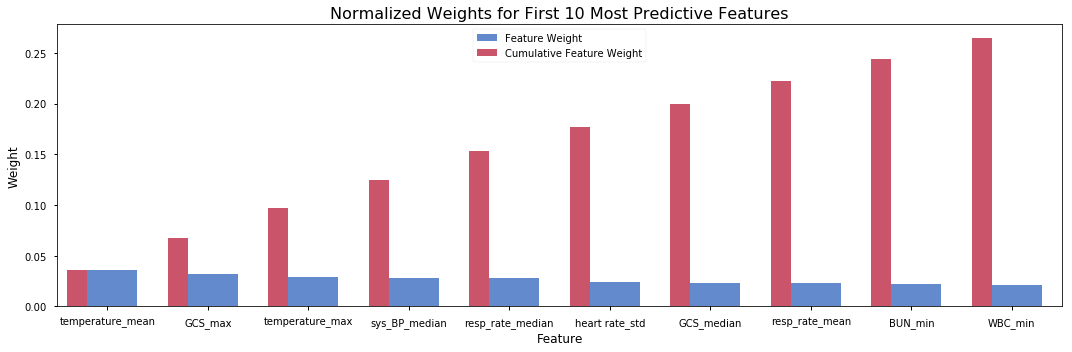

In [27]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state = 0, learning_rate=0.2, n_estimators=100, 
                                   max_depth=5, min_samples_split=100, min_samples_leaf=1)

model.fit(data_agg['X_train'], data['y_train']['in_hospital_death'])

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, data_agg['X_train'], data['y_train']['in_hospital_death'])